In [236]:
import os 
import sys
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib
#import plotting functions
from nilearn.plotting import view_img, plot_anat
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense
from keras import backend as K
import matplotlib.pyplot as plt
from PIL import Image

In [237]:
import tensorflow as tf
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.models import Model
import re 
from tensorflow.python.platform import gfile
from PIL import Image
import pickle
from sklearn.ensemble import RandomForestClassifier

In [6]:
model_dir = 'n'
images_dir = 'CN_grid/'
images_dir1 = 'AD_grid/'
list_CN = [images_dir+f for f in os.listdir(images_dir ) if re.search('PNG|png', f)]
list_AD = [images_dir1+f for f in os.listdir(images_dir1 ) if re.search('PNG|png', f)]

In [7]:
list_img = list_CN + list_AD
len(list_img)


685

In [8]:
def create_graph():
    with tf.compat.v2.io.gfile.GFile(os.path.join(model_dir, 'classify_image_graph_def.pb'), 'rb')  as f:
        graph_def = tf.compat.v1.GraphDef()
        graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')

In [9]:
def extract_features_tf(image_path):
    nb_features = 2048
    
    features = np.empty((len(list_img),nb_features))
    labels = []
    print(len(list_img))
    create_graph()
    with tf.compat.v1.Session() as sess:
        next_to_last_tensor = sess.graph.get_tensor_by_name('pool_3/_reshape:0')
        
        for ind, image in enumerate(list_img):
            if (ind%100 == 0):
                print('Processing %s...' % (image))
            

            image_data = tf.compat.v1.gfile.FastGFile(image, 'rb').read()
            predictions = sess.run(next_to_last_tensor, {'DecodeJpeg/contents:0': image_data})
            features[ind,:] = np.squeeze(predictions)
            labels.append(re.split('_\d+',image.split('/')[1])[0])
    return features, labels

In [10]:
def extract_features_keras(image_path):
    base_model = InceptionV3(include_top=False, pooling = 'avg',weights='imagenet',input_shape=(474,570,3))
    #model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg').output)
    pred = []
    for imge in image_path:
        #print(imge)
        img = image.load_img(imge)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        predictions = base_model.predict(x)
        pred.append(np.squeeze(predictions))
        
    return pred

In [257]:
features,labelss = extract_features_tf(list_img)

6052
Processing 2d/CN_side149_2.png...
Instructions for updating:
Use tf.gfile.GFile.
Processing 2d/AD_side319_2.png...
Processing 2d/CN_top162_2.png...
Processing 2d/CN_top42_3.png...
Processing 2d/CN_back55_2.png...
Processing 2d/AD_side56_2.png...
Processing 2d/AD_side319_3.png...
Processing 2d/AD_side118_1.png...
Processing 2d/AD_top143_1.png...
Processing 2d/CN_side67_3.png...
Processing 2d/CN_side109_3.png...
Processing 2d/CN_side226_3.png...
Processing 2d/AD_back294_2.png...
Processing 2d/AD_back245_1.png...
Processing 2d/AD_top109_2.png...
Processing 2d/AD_top203_1.png...
Processing 2d/CN_top267_1.png...
Processing 2d/CN_back297_1.png...
Processing 2d/CN_side325_2.png...
Processing 2d/AD_top204_2.png...
Processing 2d/AD_back149_2.png...
Processing 2d/CN_side174_2.png...
Processing 2d/CN_side129_1.png...
Processing 2d/AD_top198_3.png...
Processing 2d/CN_side39_3.png...
Processing 2d/CN_back250_2.png...
Processing 2d/AD_side49_2.png...
Processing 2d/AD_side92_1.png...
Processing 

In [112]:
#len(features)

In [11]:
b_f = extract_features_keras(list_img)

In [52]:
#placeholder array
labels= np.zeros(len(b_f))
#we know that the sick brains come after the normal ones since we just concatenated the health with the sick brains
#But your code in the bracket[]
labels[346:685] = 1

In [12]:
b_f

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
pickle.dump(features, open('features', 'wb'))
pickle.dump(labels, open('labels', 'wb'))


In [238]:
import sklearn
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.svm import SVC, LinearSVC

In [394]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)


In [395]:
clf = LinearSVC(C=1.0, loss='squared_hinge', penalty='l2',multi_class='ovr')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


/home/stud/a/aimkha18/miniconda3/envs/deep/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [396]:
def plot_confusion_matrix(y_true,y_pred):
    cm_array = confusion_matrix(y_true,y_pred)
    true_labels = np.unique(y_true)
    pred_labels = np.unique(y_pred)
    plt.imshow(cm_array[:-1,:-1], interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix", fontsize=16)
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    cbar.set_label('Number of images', rotation=270, labelpad=30, fontsize=12)
    xtick_marks = np.arange(len(true_labels))
    ytick_marks = np.arange(len(pred_labels))
    plt.xticks(xtick_marks, true_labels, rotation=90)
    plt.yticks(ytick_marks,pred_labels)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 12
    fig_size[1] = 12
    plt.rcParams["figure.figsize"] = fig_size

In [217]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    sens = TP / (TP + FN) 
    spec = TN / (FP + TN)
    print ("Sensitivity: ", sens, "Specificity:", spec)

In [398]:


print("Accuracy: {0:0.1f}%".format(accuracy_score(y_test,y_pred)*100))
perf_measure(y_test,y_pred)
#plot_confusion_matrix(y_test,y_pred)
#sensitivity = TP / (TP + FN) 96.30%
#specificity = TN / (FP + TN) 99.58%


Accuracy: 79.6%
Sensitivity:  0.6607142857142857 Specificity: 0.8888888888888888


In [399]:
from sklearn.svm import SVC, LinearSVC

from sklearn.calibration import CalibratedClassifierCV
from sklearn import svm
#from sklearn import cross_validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


clf = svm.SVC(kernel='linear', C=10).fit(X_train, y_train)
clf.score(X_test, y_test)



0.781021897810219

In [400]:
k_fold = KFold(n_splits=10, shuffle=False, random_state=0)
C_array=[0.001,0.01,0.1,1,10]
C_scores=[]

for k in C_array:
    clf = svm.SVC(kernel='linear', C=k)
    scores= cross_val_score(clf, features, labels, cv=k_fold, n_jobs=-1)
    C_scores.append(scores.mean())
    print (C_scores)

/home/stud/a/aimkha18/miniconda3/envs/deep/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


[0.635080988917306]
[0.635080988917306, 0.7630434782608696]
[0.635080988917306, 0.7630434782608696, 0.7792838874680307]
[0.635080988917306, 0.7630434782608696, 0.7792838874680307, 0.7633205456095482]
[0.635080988917306, 0.7630434782608696, 0.7792838874680307, 0.7633205456095482, 0.7648337595907928]


In [401]:
clf = svm.SVC(kernel='linear', C=0.1,probability=True)

# final_model = clf.fit(features, labels)

final_model = CalibratedClassifierCV(clf,cv=10,method='sigmoid')
final_model = clf.fit(X_train, y_train)

In [402]:
y_pred = final_model.predict(X_test)

In [403]:
print("Accuracy: {0:0.1f}%".format(accuracy_score(y_test,y_pred)*100))
perf_measure(y_test,y_pred)
#plot_confusion_matrix(y_test,y_pred)

Accuracy: 80.3%
Sensitivity:  0.6428571428571429 Specificity: 0.9135802469135802


In [425]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=1000, 
                               bootstrap = True,
                               max_features = 'sqrt')

In [426]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [427]:
# Actual class predictions
rf_predictions = model.predict(X_test)
# Probabilities for each class
rf_probs = model.predict_proba(X_test)[:, 1]

#We make class predictions (predict) as well as predicted probabilities (predict_proba) 
#to calculate the ROC AUC. Once we have the testing predictions, we can calculate the ROC AUC.

In [428]:
roc_value = roc_auc_score(y_test, rf_probs)

In [429]:
print(roc_value)
#print(rf_predictions)

0.8477733686067019


In [430]:
print("Accuracy: {0:0.1f}%".format(accuracy_score(y_test,rf_predictions)*100))
#plot_confusion_matrix(y_test,rf_predictions)
perf_measure(y_test,rf_predictions)

Accuracy: 79.6%
Sensitivity:  0.7142857142857143 Specificity: 0.8518518518518519


In [432]:
scores = cross_val_score(model, features, labels, scoring='accuracy', cv=5)
print (scores)
print (scores.mean())

[0.7810219  0.79562044 0.76642336 0.82481752 0.78832117]
0.7912408759124088


Trying another version pretrained network inceptionv3

In [372]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [406]:
#https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part3.ipynb?utm_source=practicum-IC&utm_campaign=colab-external&utm_medium=referral&hl=en&utm_content=imageexercise3-colab
local_weights_file = '/home/stud1/a/aimkha18/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape=(87, 87, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

#pre_trained_model.summary()

In [407]:
for layer in pre_trained_model.layers:
    #print (layer)
    layer.trainable = False
#pre_trained_model.summary()

In [408]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output
print(last_output)

last layer output shape: (None, 3, 3, 768)
Tensor("mixed7_6/Identity:0", shape=(None, 3, 3, 768), dtype=float32)


In [431]:

base_model = tf.keras.Sequential([
  pre_trained_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1, activation='sigmoid')
])



base_model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['acc'])
base_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 1, 1, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [410]:
base_dir = '/home/stud1/a/aimkha18/Thesis/tmp2/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [411]:
# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'CN')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'AD')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'CN')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'AD')

In [412]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[1])
"""img = load_img('/home/stud1/a/aimkha18/Thesis/tmp/train/CN/merge_top148.png')  # this is a PIL image
x = img_to_array(img)
print(x.shape)"""

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

CN_back158_1.png
['.ipynb_checkpoints', 'AD_back100_1.png', 'AD_back100_2.png', 'AD_back100_3.png', 'AD_back101_1.png', 'AD_back101_2.png', 'AD_back101_3.png', 'AD_back102_1.png', 'AD_back102_2.png', 'AD_back102_3.png']


In [413]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 2420
total training dog images: 2421
total validation cat images: 454
total validation dog images: 454


In [414]:
"""images_dir = 'CN_grid/'
images_dir1 = 'AD_grid/'
list_CN = [images_dir+'/'+f for f in os.listdir(images_dir) if re.search('PNG|png', f)]
list_AD = [images_dir1+'/'+f for f in os.listdir(images_dir1) if re.search('PNG|png', f)]
print("AD: ", len(list_AD), "CN", len(list_CN))
list_X = list_CN+list_AD"""

'images_dir = \'CN_grid/\'\nimages_dir1 = \'AD_grid/\'\nlist_CN = [images_dir+\'/\'+f for f in os.listdir(images_dir) if re.search(\'PNG|png\', f)]\nlist_AD = [images_dir1+\'/\'+f for f in os.listdir(images_dir1) if re.search(\'PNG|png\', f)]\nprint("AD: ", len(list_AD), "CN", len(list_CN))\nlist_X = list_CN+list_AD'

In [415]:
"""def load_all_data(list_X):
    data=[]
    temp=[]
    for imge in list_X:
        #print(imge)
        img = image.load_img(imge)
        temp = image.img_to_array(img)
        #print (np.expand_dims(temp,0),0)
     
        data.append(temp)
       

    return data



#train_x = loadedImages"""

'def load_all_data(list_X):\n    data=[]\n    temp=[]\n    for imge in list_X:\n        #print(imge)\n        img = image.load_img(imge)\n        temp = image.img_to_array(img)\n        #print (np.expand_dims(temp,0),0)\n     \n        data.append(temp)\n       \n\n    return data\n\n\n\n#train_x = loadedImages'

In [416]:
#data = load_all_data(list_X)


In [417]:
"""labels= np.zeros(len(data))
#we know that the sick brains come after the normal ones since we just concatenated the health with the sick brains
#But your code in the bracket[]
labels[346:685] = 1"""

'labels= np.zeros(len(data))\n#we know that the sick brains come after the normal ones since we just concatenated the health with the sick brains\n#But your code in the bracket[]\nlabels[346:685] = 1'

In [418]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    #rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    #shear_range=0.2,
    zoom_range=0.08
    #horizontal_flip=True
    )


# All images will be rescaled by 1./255
val_datagen = ImageDataGenerator(rescale=1./255)

In [419]:
tr_batch = 33
val_batch = 20
tr_img = 4840
val_img = 908
train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(87, 87),  # All images will be resized to 150x150
        batch_size=tr_batch,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary',
        shuffle = True)


Found 4841 images belonging to 2 classes.


In [420]:
# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(87, 87),
        batch_size=val_batch,
        class_mode='binary',
        shuffle = True)



Found 908 images belonging to 2 classes.


In [421]:
#X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


In [422]:
#X = np.array(X_train)

In [423]:
print(validation_generator.class_indices)

{'AD': 0, 'CN': 1}


In [426]:
history = base_model.fit_generator(
      train_generator,
      steps_per_epoch=tr_img/tr_batch,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=val_img/val_batch,
      verbose=1)

Epoch 1/10
147/146 [==============================] - 207s 1s/step - loss: 0.7259 - accuracy: 0.4825 - val_loss: 0.7980 - val_accuracy: 0.5011
Epoch 2/10
147/146 [==============================] - 205s 1s/step - loss: 0.7101 - accuracy: 0.5024 - val_loss: 0.8012 - val_accuracy: 0.5077
Epoch 3/10
147/146 [==============================] - 204s 1s/step - loss: 0.7053 - accuracy: 0.5181 - val_loss: 0.8004 - val_accuracy: 0.5044
Epoch 4/10
147/146 [==============================] - 205s 1s/step - loss: 0.7015 - accuracy: 0.5259 - val_loss: 0.8004 - val_accuracy: 0.5099
Epoch 5/10
147/146 [==============================] - 205s 1s/step - loss: 0.6926 - accuracy: 0.5493 - val_loss: 0.8132 - val_accuracy: 0.5198
Epoch 6/10
147/146 [==============================] - 206s 1s/step - loss: 0.6940 - accuracy: 0.5352 - val_loss: 0.8178 - val_accuracy: 0.5231
Epoch 7/10
147/146 [==============================] - 206s 1s/step - loss: 0.6821 - accuracy: 0.5604 - val_loss: 0.8298 - val_accuracy: 0.5165

KeyError: 'validation_accuracy'

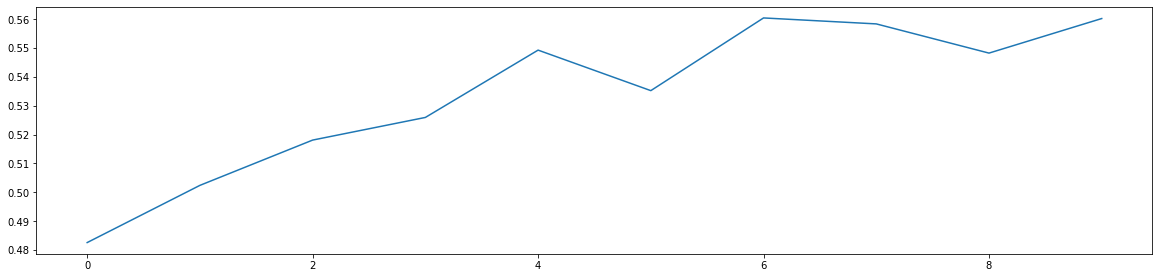

In [430]:


plt.figure(1, figsize=(20,10))  
#odd. need to run above twice to set plot size
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['validation_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()



In [432]:
from tensorflow.keras.optimizers import SGD

unfreeze = False

# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
    print(layer.name, "is now trainable")
  if layer.name == 'mixed6':
    unfreeze = True
    print(layer.name, "is now unfrozen")



mixed6 is now unfrozen
conv2d_628 is now trainable
batch_normalization_628 is now trainable
activation_628 is now trainable
conv2d_629 is now trainable
batch_normalization_629 is now trainable
activation_629 is now trainable
conv2d_625 is now trainable
conv2d_630 is now trainable
batch_normalization_625 is now trainable
batch_normalization_630 is now trainable
activation_625 is now trainable
activation_630 is now trainable
conv2d_626 is now trainable
conv2d_631 is now trainable
batch_normalization_626 is now trainable
batch_normalization_631 is now trainable
activation_626 is now trainable
activation_631 is now trainable
average_pooling2d_60 is now trainable
conv2d_624 is now trainable
conv2d_627 is now trainable
conv2d_632 is now trainable
conv2d_633 is now trainable
batch_normalization_624 is now trainable
batch_normalization_627 is now trainable
batch_normalization_632 is now trainable
batch_normalization_633 is now trainable
activation_624 is now trainable
activation_627 is now tra

In [305]:
# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)
base_model.compile(loss='binary_crossentropy',
              optimizer=SGD(
                  lr=0.00001, 
                  momentum=0.9),
              metrics=['acc'])

In [433]:
history1 = base_model.fit_generator(
      train_generator,
      steps_per_epoch=tr_img/tr_batch,
      epochs=55,
      validation_data=validation_generator,
      validation_steps=val_img/val_batch,
      verbose=1)

Epoch 1/55
147/146 [==============================] - 204s 1s/step - loss: 0.7346 - acc: 0.5057 - val_loss: 0.7331 - val_acc: 0.5363
Epoch 2/55
147/146 [==============================] - 205s 1s/step - loss: 0.7237 - acc: 0.5038 - val_loss: 0.7306 - val_acc: 0.5308
Epoch 3/55
147/146 [==============================] - 205s 1s/step - loss: 0.7204 - acc: 0.5090 - val_loss: 0.7333 - val_acc: 0.5308
Epoch 4/55
147/146 [==============================] - 203s 1s/step - loss: 0.7164 - acc: 0.5067 - val_loss: 0.7402 - val_acc: 0.5275
Epoch 5/55
147/146 [==============================] - 204s 1s/step - loss: 0.7184 - acc: 0.5115 - val_loss: 0.7407 - val_acc: 0.5297
Epoch 6/55
147/146 [==============================] - 203s 1s/step - loss: 0.7143 - acc: 0.5168 - val_loss: 0.7415 - val_acc: 0.5297
Epoch 7/55
147/146 [==============================] - 203s 1s/step - loss: 0.7102 - acc: 0.5135 - val_loss: 0.7395 - val_acc: 0.5308
Epoch 8/55
147/146 [==============================] - 204s 1s/step - 

KeyboardInterrupt: 

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history1.history['acc']
val_acc = history1.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')